## Importing Modules :

In [40]:
# installing optax and flax in colab! for optimization
from jax.config import config
config.update("jax_enable_x64", True)  #double precision

In [45]:
import jax.numpy as jnp
import json
import sys
from skopt.space import Space
from skopt.sampler import Halton
from jax import jacfwd

# Special Transform Functions
from jax import grad, jit, vmap, pmap
import jax
from jax import jit

from jax._src.lax.utils import (
    _argnum_weak_type,
    _input_dtype,
    standard_primitive,)
from jax._src.lax import lax

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import prk_for_optimization as IRK4


KeyboardInterrupt: 

# Functions :

In [43]:
def One_Dim_Matrix(A):
    """
    We use this function to convert a 2D array into a 1D array containing only the lower triangular matrix of the 2D array.
    : param A : a 2D array
    : return : a 1D array

    """
    dim_x, dim_y = A.shape
    #print(dim_x, dim_y)
    A = A.reshape(1, (dim_x * dim_y))
    return A


def Add_B_tomatrix_A(A, b):
    """
    Given 2 1D arrays this function appends the second array at the end of first array.
    : param A : 1D array
    : param b : 1D array
    : return : 1D array after appending array b to A

    """
    A = jnp.append(A,b)
    return A


def Aminus(M, dr):
    """
    THis function subtracts dr from M and then return the updated value of M
    : param M : 1D array
    : param dr : 1D array
    : return : 1D array after subtracting dr from M

    """

    M = M, dr
    return M


def Aplus(M, dr):
    """
    THis function add dr to M and then return the updated value of M
    : param M : 1D array
    : param dr : 1D array
    : return : 1D array after adding dr to M

    """

    M = jnp.add(M, dr)
    return M


def actual_A_1D(A):
    """
    This function takes in a 1D array and breaks it into 2 arrays.
    : param A : 1D array
    : return A_new : 1D array of length = 10
    : return b1 : 1D array of length = 4

    """

    b1 = A[16:20]
    A_new = A[0:16]
    return A_new, b1


def actual_A1_A2(A): # from the returned gradient array of 20 elements, we find the elements of array A and array B
                    # first 16 elemets belong to lower triangular elements of array A and 4 belongs to B
    A1 = A[0:20]
    A2 = A[20:40]
    H_sequence = A[40:]
    return A1, A2, H_sequence


def One_D_to_TwoD(A):
    """
    Using a 1D array, returned by the function @actual_A_1D , making a lower triangular matrix A2D
    : param A : 1D array of length = 10
    : return : 2D array

    """
    A = A.reshape(4, 4)
    return A

"""
 : using the initial matrix A and B from the source given below :
 : wiki link : https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods#:~:text=is%5B13%5D-,0,1/6,-A%20slight%20variation
"""

# Lobatto 3A and B fourth order
A1 = jnp.array([
     [0., 0., 0., 0.],
     [5/24, 1/3, -1/24, 0.],
     [1/6, 2/3, 1/6, 0.],
     [0., 0., 0., 0.]])
B1 = jnp.array([1/6, 2/3, 1/6, 0.])

# Lobatto IIIB fourth-order
A2 = jnp.array([
     [1/6, -1/6, 0., 0.],
     [1/6, 1/3, 0., 0.],
     [1/6, 5/6, 0., 0.],
     [0., 0., 0., 0.]])
B2 = jnp.array([1/6, 2/3, 1/6, 0.])

## Lobatto IIIB methods are A-stable, but not L-stable and B-stable.

## Making the Halton code

spacedim = [(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5),(-1.0, 0.5) ]

space = Space(spacedim)

halton = Halton()
n = 100

halton_sequence = halton.generate(space, n)
halton_sequence = jnp.array(halton_sequence)


## ADAgrad using optax

In [46]:
# Initial A1D
import optax

A1D = One_Dim_Matrix(A1)
A1D = Add_B_tomatrix_A(A1D, B1)
A2D = One_Dim_Matrix(A2)
A2D = Add_B_tomatrix_A(A2D, B2)
A1D = Add_B_tomatrix_A(A1D, A2D)
print(A1D.shape)

learning_rate = 0.1
list_optimizers = [optax.adam(learning_rate)]
# chosing Stochastic Gradient Descent Algorithm.
# # We have created a list here keeping in mind that we may apply all the optimizers in optax by storing their objects in the list
 
opt_sgd = list_optimizers[0]
opt_state = opt_sgd.init(A1D)

params = A1D

count = 0
data_epoc = 10
data_epoc_list = []
repetetion = 10
# length of halton sequence = 10 

tot_eror = 0
error_list_1 = [] 
error_list_2 = []

flat_halton_sequence = jnp.array(halton_sequence).reshape(-1, 6)

batch_size = 100

def compute_grads_single(A1D, h_element):
    grad_fn = jax.jacfwd(IRK4.find_error)
    return grad_fn(A1D, h_element)

def compute_error_single(A1D, h_element):
    return IRK4.find_error(A1D, h_element)

# Use jax.vmap to vectorize the function over the batch
compute_grads_batched = jax.vmap(compute_grads_single, in_axes=(None, 0))
compute_error_batched = jax.vmap(compute_error_single, in_axes=(None, 0))

error_list_1 = [] 
error_list_2 = []
tot_error = 0
for k in trange(1000):
    tot_error = 0

    for batch_idx in range(0, len(flat_halton_sequence), batch_size):
        # Collect a batch of elements from the flattened Halton sequence
        batch_halton = flat_halton_sequence[batch_idx:batch_idx + batch_size]

        # Compute the gradients for the batch using jax.vmap
        gradF = compute_grads_batched(A1D, batch_halton)

        # Compute the average gradient for the batch
        avg_gradF = jnp.mean(gradF, axis=0)

        # Perform one step of optimization using the averaged gradient
        updates, opt_state = opt_sgd.update(avg_gradF, opt_state)

        # Apply the updates to the weights A1D for the entire batch
        A1D = optax.apply_updates(A1D, updates)

        # Calculate the total error for the batch and accumulate it
        batch_error = jnp.mean(compute_error_batched(A1D, batch_halton))
        tot_error += batch_error

    avg_error = tot_error / (len(flat_halton_sequence) // batch_size)
    error_list_1.append(avg_error)
  
    tot_error = 0
    for mm in range(len(halton_sequence)):
        tot_error += IRK4.find_error(A1D, halton_sequence[mm])
  
    error_list_2.append(tot_error / len(halton_sequence))

    A1D = A1D[:40]
    
    new_A1, new_B1 = actual_A_1D(A1D[0:20])
    new_A2, new_B2 = actual_A_1D(A1D[20:40])

    #converting A to a 2D Array
    new_A1 = One_D_to_TwoD(new_A1)
    new_A2 = One_D_to_TwoD(new_A2)
    
    
    # Saving to a json file.
    json_A1 = new_A1.tolist()
    json_A2 = new_A2.tolist()
    json_B1 = new_B1.tolist()
    json_B2 = new_B2.tolist()

    # Combine data into a dictionary
    data = {
        'A1': json_A1,
        'A2': json_A2,
        'B1': json_B1,
        'B2': json_B2
    }
    
    file_path = 'BatchOutput.json'

    # Save the data to BatchOutput.json
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file)

    # print(f'Data saved to {file_path}')
    
    

(40,)


 66%|██████▌   | 659/1000 [23:05<14:54,  2.62s/it]

In [ ]:
print(error_list_2[::-1])
print(len(error_list_2))
print(len(error_list_1))

[Array(0.00200544, dtype=float64), Array(0.00044527, dtype=float64), Array(0.00451099, dtype=float64), Array(0.003243, dtype=float64), Array(0.00511002, dtype=float64), Array(0.00374481, dtype=float64), Array(0.00016734, dtype=float64), Array(0.00207853, dtype=float64), Array(0.00073213, dtype=float64), Array(0.00022326, dtype=float64), Array(0.00115821, dtype=float64), Array(0.00018509, dtype=float64), Array(0.00014467, dtype=float64), Array(0.00081083, dtype=float64), Array(0.00031798, dtype=float64), Array(0.0002558, dtype=float64), Array(0.00118629, dtype=float64), Array(0.0004958, dtype=float64), Array(2.60841049e-05, dtype=float64), Array(0.00056513, dtype=float64), Array(0.00074251, dtype=float64), Array(0.0009166, dtype=float64), Array(0.0001175, dtype=float64), Array(0.00054619, dtype=float64), Array(0.00241597, dtype=float64), Array(0.0009198, dtype=float64), Array(0.00027603, dtype=float64), Array(7.02861988e-05, dtype=float64), Array(0.00021292, dtype=float64), Array(0.0003

# Loading the data from the Json File

In [ ]:
import json
import jax.numpy as jnp

# File path
file_path = 'output.json'

# Reading the data from the JSON file
with open(file_path, 'r') as json_file:
    loaded_data = json.load(json_file)

# Converting the data back to jax.numpy
loaded_A1 = jnp.array(loaded_data['A1'])
loaded_A2 = jnp.array(loaded_data['A2'])
loaded_B1 = jnp.array(loaded_data['B1'])
loaded_B2 = jnp.array(loaded_data['B2'])

print("upadated A1 : \n", loaded_A1, "\n")
print("upadated A2 : \n", loaded_A2, "\n")
print("upadated B1 : \n", loaded_B1, "\n")
print("upadated B2 : \n", loaded_B2, "\n")

[[-0.03680254 -0.03914029 -0.01033246 -0.01334874]
 [ 0.03270048  0.15750363 -0.17963157 -0.14644805]
 [-0.17683075  0.34472979 -0.14277709 -0.35772374]
 [-0.05223136 -0.06476019 -0.06054808 -0.02731196]]
[[ 0.11414877 -0.21735383 -0.03403843 -0.04395243]
 [ 0.02313215  0.19462848 -0.1288288  -0.13709178]
 [-0.05996464  0.6053328  -0.20515508 -0.23103029]
 [ 0.01685655  0.01655294  0.02455329  0.02932217]]


# Saving new_A1, new_A2 and new_B1, new_B2 into a json file:

In [ ]:
# import json


# json_A1 = new_A1.tolist()
# json_A2 = new_A2.tolist()
# json_B1 = new_B1.tolist()
# json_B2 = new_B2.tolist()

# # Combine data into a dictionary
# data = {
#     'A1': json_A1,
#     'A2': json_A2,
#     'B1': json_B1,
#     'B2': json_B2
# }

# # path of JSON file
# file_path = 'BatchOutput.json'

# # Save the data to a JSON file
# with open(file_path, 'w') as json_file:
#     json.dump(data, json_file)

# print(f'Data saved to {file_path}')


Data saved to output.json


# Tests

In [ ]:
import tests

test_func = [ tests.F, tests.FyF, tests.FzG, tests.FyyFF, tests.FyzFG, tests.FzzGG, tests.FyFyF, tests.FyFzG, tests.FzGyF, tests.FzGzG,
              tests.G, tests.GyF, tests.GzF, tests.GzzGG, tests.GzyGF, tests.GyyFF, tests.GzGzG, tests.GyGzF, tests.GyFzG, tests.GzFzF]

for func in test_func :
    print(func(new_B1, new_B2, new_A1, new_A2))


TypeError: F() takes 1 positional argument but 4 were given

In [31]:
print(error_list_2)
a = []
for i in range(20):
    a.append(i)

b = a[16:20]
b = jnp.array(b)
b = b.reshape(4,1)
print(b.shape)

[Array(7.37964498e-05, dtype=float64), Array(2.53724068e-05, dtype=float64), Array(8.23970448e-05, dtype=float64), Array(2.58473399e-05, dtype=float64), Array(8.22477399e-05, dtype=float64), Array(2.59902363e-05, dtype=float64), Array(8.21119581e-05, dtype=float64), Array(2.61208897e-05, dtype=float64), Array(8.19812272e-05, dtype=float64), Array(2.62475086e-05, dtype=float64), Array(8.18506723e-05, dtype=float64), Array(2.63739544e-05, dtype=float64), Array(8.17204962e-05, dtype=float64), Array(2.65009026e-05, dtype=float64), Array(8.15903711e-05, dtype=float64), Array(2.66273609e-05, dtype=float64), Array(8.14607174e-05, dtype=float64), Array(2.67533574e-05, dtype=float64), Array(8.13315079e-05, dtype=float64), Array(2.68790144e-05, dtype=float64), Array(8.12021686e-05, dtype=float64), Array(2.70049704e-05, dtype=float64), Array(8.10735511e-05, dtype=float64), Array(2.71302217e-05, dtype=float64), Array(8.09456116e-05, dtype=float64), Array(2.72548107e-05, dtype=float64), Array(8.081

In [32]:
print(error_list_2)
print(new_B1)
print(new_B2)

[Array(7.37964498e-05, dtype=float64), Array(2.53724068e-05, dtype=float64), Array(8.23970448e-05, dtype=float64), Array(2.58473399e-05, dtype=float64), Array(8.22477399e-05, dtype=float64), Array(2.59902363e-05, dtype=float64), Array(8.21119581e-05, dtype=float64), Array(2.61208897e-05, dtype=float64), Array(8.19812272e-05, dtype=float64), Array(2.62475086e-05, dtype=float64), Array(8.18506723e-05, dtype=float64), Array(2.63739544e-05, dtype=float64), Array(8.17204962e-05, dtype=float64), Array(2.65009026e-05, dtype=float64), Array(8.15903711e-05, dtype=float64), Array(2.66273609e-05, dtype=float64), Array(8.14607174e-05, dtype=float64), Array(2.67533574e-05, dtype=float64), Array(8.13315079e-05, dtype=float64), Array(2.68790144e-05, dtype=float64), Array(8.12021686e-05, dtype=float64), Array(2.70049704e-05, dtype=float64), Array(8.10735511e-05, dtype=float64), Array(2.71302217e-05, dtype=float64), Array(8.09456116e-05, dtype=float64), Array(2.72548107e-05, dtype=float64), Array(8.081

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Error')

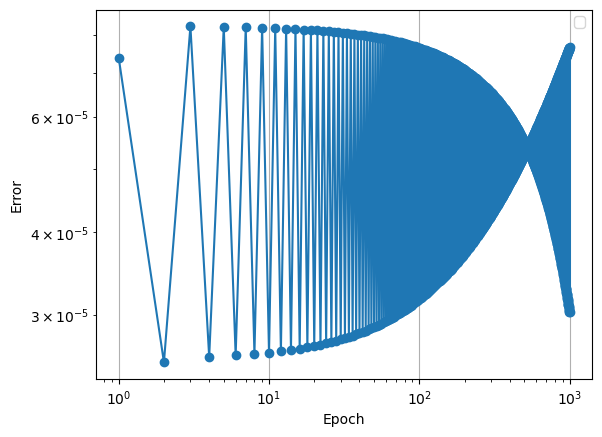

In [33]:
import matplotlib.pyplot as plt
a = list(range(1,len(error_list_2)+1))

# Convergence
# for i in range(0, len(error_list_1)):
plt.loglog(a, error_list_2, label = "",marker='o')
    


# plt.plot(step_size_list_convergence, error_list_convergence, label = "Error",marker='o')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

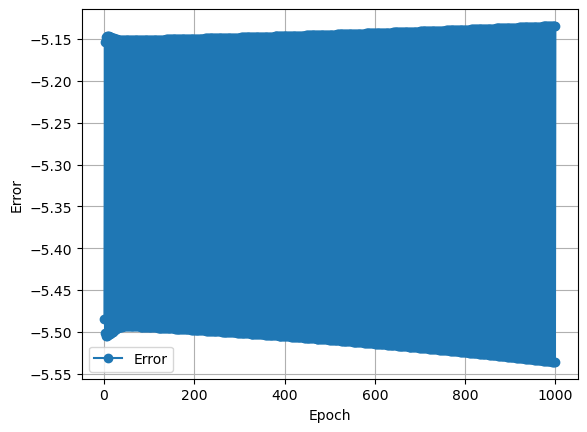

In [27]:
a = list(range(1,len(error_list_2)+1))

# Convergence
# for i in range(0, len(error_list_1)):

# plt.loglog(a, error_list_2, label = "",marker='o')
    
error_list_convergence = jnp.array(error_list_2)
error_list_convergence = jnp.log(error_list_convergence) / jnp.log(10)
plt.plot(a, error_list_convergence, label = "Error",marker='o')


plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Error')

# Now applying the updated value to the PRK method, and checking the convergence, dynamic and contour plots

In [118]:

# RK4 4th order Table

A1 = new_A1
A2 = new_A2

B1 = new_B1
B2 = new_B2

@jit
def f(y, z):
    return z
@jit
def g(y, z):
    return -y


def Energy_Function(y, z):
    return (jnp.square(y) + jnp.square(z))/2

@jit
def PRK_step(y0 , z0, h, A1, A2, B1, B2):
    s = A1.shape[0]
    dim = jnp.size(y0)
    tol = 10**(-10)
    K_old = jnp.zeros((s,dim))
    L_old = jnp.zeros((s,dim))

    K_new = f((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old))
    L_new = g((y0+ h*A1 @ K_old), (z0+ h*A2 @ L_old))

    init_state = 0, K_new, L_new, K_old, L_old
    
    @jit
    def body_while_loop(state):
        _, K_new, L_new, K_old, L_old = state
        K_old = K_new
        L_old = L_new
        K_new = f(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old)
        L_new = g(y0+ h * A1 @ K_old, z0 + h * A2 @ L_old)

        return _, K_new, L_new, K_old, L_old
    
    @jit
    def condition_while_loop(state):
        _, K_new, L_new, K_old, L_old = state
        norms = jnp.sum(jnp.array([jnp.linalg.norm(K_new - K_old) + jnp.linalg.norm(L_new - L_old)]))
        return norms > tol

    _, K_new, L_new, K_old, L_old = jax.lax.while_loop(condition_while_loop, body_while_loop, init_state)
    yn = y0 + h * B1 @ K_new
    zn = z0 + h * B2 @ L_new

    return yn, zn

def fori_loop_2(j, state):
    iyn_list, izn_list, iy, iz, A1, A2, B1, B2 = state
    iy, iz = PRK_step(iy, iz, h/istep, A1, A2, B1, B2)
    iyn_list = iyn_list.at[j].set(iy.ravel())
    izn_list = izn_list.at[j].set(iz.ravel())
    state = iyn_list, izn_list, iy, iz, A1, A2, B1, B2

    return state

def fori_loop_1(i, state):
    yn_list, zn_list, y, z, A1, A2, B1, B2 = state
    y, z = PRK_step(y, z, h, A1, A2, B1, B2)
    yn_list = yn_list.at[i].set(y.ravel())
    zn_list = zn_list.at[i].set(z.ravel())
    state = yn_list, zn_list, y, z, A1, A2, B1, B2

    return state


if __name__ == "__main__":
    time_factor = 1 # default

    y0 = jnp.zeros((1,1))
    z0 = jnp.ones((1,1))

    NN = jnp.array([1, 10, 100, 1000])
    istep = 10
    step_size_list_convergence = []
    o_error_list_convergence = []
    c_error_list_convergence = []

    for i in range(len(NN)):
        yn_list = jnp.zeros((time_factor * NN[i], 1))
        zn_list = jnp.zeros((time_factor * NN[i], 1))
        iyn_list = jnp.zeros((time_factor * istep * NN[i] , 1))
        izn_list = jnp.zeros((time_factor * istep * NN[i] , 1))

        yn = zn = iyn = izn = []
        h = 1/NN[i] #step size
        y = iy = y0
        z = iz = z0
        
        init_state_yz = yn_list, zn_list, y, z, A1, A2, B1, B2
        yn_list, zn_list, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * NN[i], fori_loop_1, init_state_yz)
        
        init_state_iyz = iyn_list, izn_list, iy, iz, A1, A2, B1, B2
        iyn_list, izn_list, _, _, _, _, _, _ = jax.lax.fori_loop(0, time_factor * istep * NN[i], fori_loop_2, init_state_iyz) # time istep
        j1_iyn_list = iyn_list[9:time_factor*istep*NN[i]:10]
        j2_izn_list = izn_list[9:time_factor*istep*NN[i]:10]

        # this is for calculating the original error
        tt1 =  jnp.linspace(h, 1, NN[i]*time_factor)
        sine_value = jnp.sin(tt1)
        cosine_value = jnp.cos(tt1)

        # Finding error using original Value
        err1 = yn_list.ravel() - sine_value #(yn_list, sine_value)
        err2 = zn_list.ravel() - cosine_value #(zn_list, cosine_value)

        original_error = jnp.sqrt((jnp.sum(jnp.square(err1))   ) / ( NN[i]))

        o_error_list_convergence.append(original_error)
        """   """
        # Finding error using original Value

        #### Calculating error with the smaller steps :
        print("======")
        print(j1_iyn_list.shape)
        print(yn_list.shape)
        print("======")

        err1 = j1_iyn_list.ravel() - yn_list.ravel()
        err2 = j2_izn_list.ravel() - zn_list.ravel()

        final_error = (jnp.sum(jnp.abs(err1)) + jnp.sum(jnp.abs(err2))) / (2*NN[i])

        #### Calculating error with the smaller steps :
        c_error_list_convergence.append(final_error)
        step_size_list_convergence.append(h)






(1, 1)
(1, 1)
(10, 1)
(10, 1)
(100, 1)
(100, 1)
(1000, 1)
(1000, 1)


In [119]:
# print(yn_list)

Text(0, 0.5, 'Log Error')

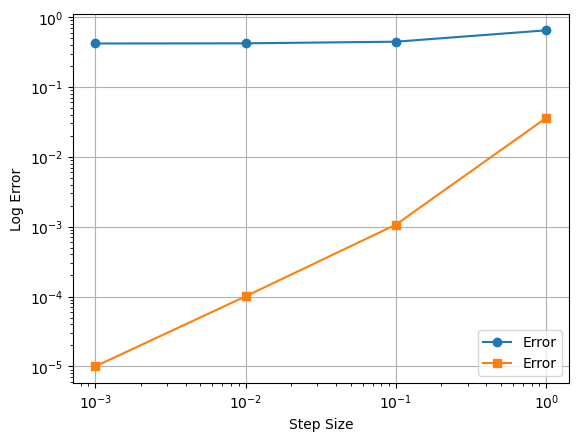

In [120]:
import matplotlib.pyplot as plt

# Convergence

# o_error_list_convergence = jnp.array(o_error_list_convergence)
# o_error_list_convergence = jnp.log(o_error_list_convergence) / jnp.log(10)
# c_error_list_convergence = jnp.array(c_error_list_convergence)
# c_error_list_convergence = jnp.log(c_error_list_convergence)/jnp.log(10)
# plt.plot(step_size_list_convergence, o_error_list_convergence, label = "Error",marker='o')
# plt.plot(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')


plt.loglog(step_size_list_convergence, o_error_list_convergence, label = "Error",marker='o')
plt.loglog(step_size_list_convergence, c_error_list_convergence, label = "Error",marker='s')

plt.legend()
plt.grid()
plt.xlabel('Step Size')
plt.ylabel('Log Error')

Text(0, 0.5, 'Log Error')

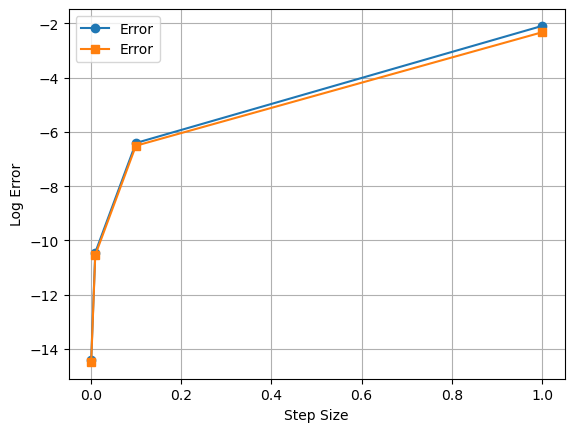

In [117]:
# import matplotlib.pyplot as plt

# # Convergence

# oo_error_list_convergence = jnp.array(o_error_list_convergence)
# oo_error_list_convergence = jnp.log(oo_error_list_convergence) / jnp.log(10)
# cc_error_list_convergence = jnp.array(c_error_list_convergence)
# cc_error_list_convergence = jnp.log(cc_error_list_convergence)/jnp.log(10)
# plt.plot(step_size_list_convergence, oo_error_list_convergence, label = "Error",marker='o')
# plt.plot(step_size_list_convergence, cc_error_list_convergence, label = "Error",marker='s')


# plt.legend()
# plt.grid()
# plt.xlabel('Step Size')
# plt.ylabel('Log Error')

1000


Text(0, 0.5, 'x')

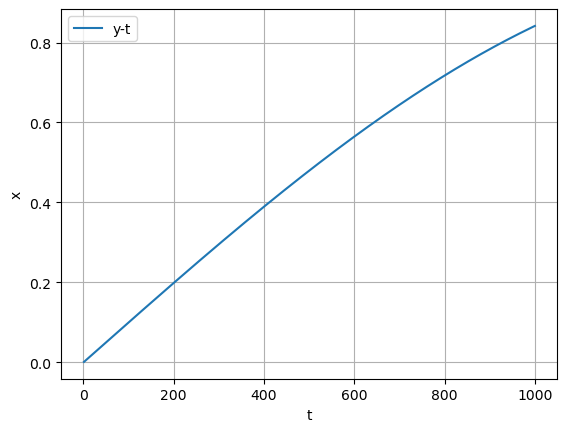

In [95]:
print(len(yn_list))
t2 = jnp.arange(1, 1001, 1)
plt.plot(t2, yn_list, label = "y-t", )
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x')
     

Text(0, 0.5, 'x')

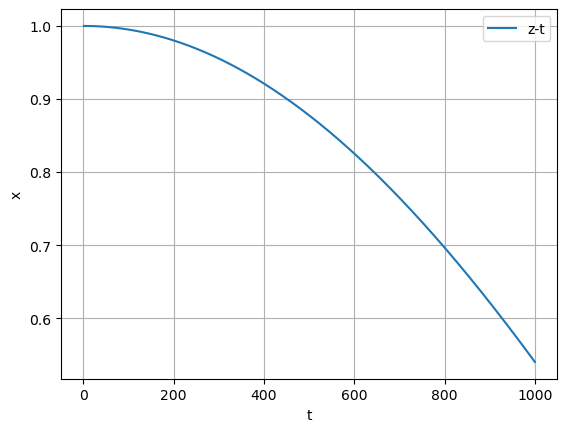

In [70]:
t2 = jnp.arange(1, 1001, 1)
plt.plot(t2, zn_list, label = "z-t", )
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('x')

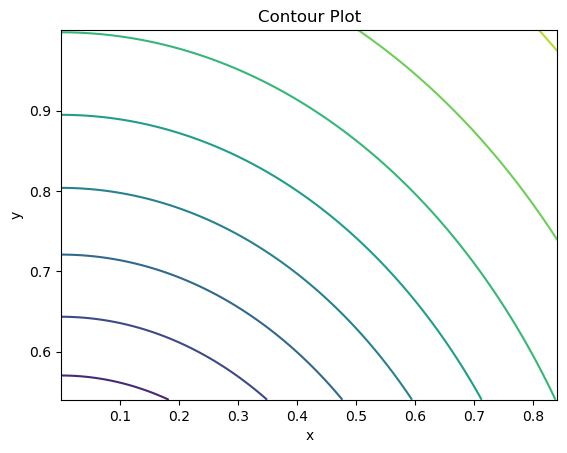

In [71]:
x = yn_list
x = x.flatten()
y = zn_list
y = y.flatten()
X, Y = jnp.meshgrid(x, y)
Z = jnp.sin(jnp.sqrt(X**2 + Y**2))

# Create the contour plot
plt.contour(X, Y, Z)
plt.title('Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## energy Error :


In [39]:
C = jnp.zeros((len(yn_list)))

for i in trange(0, len(yn_list)):
    i_start = i *10
    i_end = i_start + 10
    C = C.at[i].set(jnp.sum((yn_list[i] - yn_list[0][i_start:i_end])**2))
    
print(C)

100%|██████████| 1000/1000 [00:02<00:00, 495.54it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.